# Project 5 : CS548 - Text Mining: Spot Deceptive TripAdvisor Hotel's Reviews

** http://web.cs.wpi.edu/~cs548/f16/Projects/Project5/ **

** Notebook URL: https://github.com/yousef-fadila/cs548-project-5/blob/master/notebook.ipynb ** 

** By: Yousef Fadila ** 

# Guiding Quesions:

1) which is more prevalent, positive deceptive or negative deceptive? what is the deceptive ratio among the truthful reviews?

2) who are the top ten hotels with deceptive positive reviews? Is deceptive positive reviews ratio is common in specific hotels star rating? 

3) what are the common review sequences followed by deceptive positive reviews? In particular do deceptive positive reviews are used to cover on previous truthful negative reviews? 
 
4) would a 2-steps approach based on domain knowledge (like the one presented on anomaly detection showcase) improves the accuracy of the model? 

Training data:
-- Deceptive Opinion Spam Corpus v1.4 - downloaded from http://myleott.com/op_spam/

Examination data:
--  TripAdvisor reviews downloaded from http://myleott.com/op_spam/

In [814]:
# Global Import
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pylab as py
import matplotlib.pyplot as plt
import scipy
from IPython.display import HTML
from datetime import datetime, date, time
from sklearn.svm import LinearSVC
lastRunTime = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
import re
from sklearn import tree
import json
%matplotlib inline

In [815]:
# load training data: load Deceptive Opinion Spam Corpus
dataset = load_files('training-data', encoding='utf-8', decode_error='replace',shuffle=False)
print("n_samples: %d" % len(dataset.data))

print("Done: " + lastRunTime)

n_samples: 1602
Done: 2016-12-05 03:40:44


In [824]:
# split the dataset in training and test set:
docs_train, docs_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target, test_size=0.10, random_state=None)
min_df=3
max_df=0.96
# ngram (1,3) gives better percsion than 1,2 and 1,4 doesn't improve accuracy. 
ngram_range = (1,3) 
TfidfVect= TfidfVectorizer(min_df = min_df, max_df = max_df, ngram_range = ngram_range).fit(docs_train)
Xtrain = TfidfVect.transform(docs_train).toarray()
print("Xtrain:" + str(Xtrain.shape))
Xtest = TfidfVect.transform(docs_test).toarray()
print("Xtest:" + str(Xtest.shape))

#clf = tree.DecisionTreeClassifier()
clf  = LinearSVC(C=1000)

clf.fit(Xtrain, y_train)
y_predicted = clf.predict(Xtest)

print("Done: " + lastRunTime)

Xtrain:(1441, 22440)
Xtest:(161, 22440)
Done: 2016-12-05 03:40:44


**Classification Report**

                    precision    recall  f1-score   support

negative_deceptive       0.92      0.81      0.86        42
 negative_truthful       0.83      0.88      0.85        40
positive_deceptive       0.81      0.98      0.89        44
 positive_truthful       0.93      0.77      0.84        35

       avg / total       0.87      0.86      0.86       161

**Confusion Matrix**

[[34  6  2  0]
 [ 3 35  1  1]
 [ 0  0 43  1]
 [ 0  1  7 27]]
0: negative_deceptive  1: negative_truthful
2: positive_deceptive  3: positive_truthful


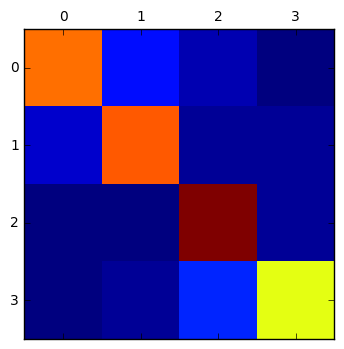

In [825]:
# Print the classification report
print("**Classification Report**\n")
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

# Print and plot the confusion matrix
print("**Confusion Matrix**\n")
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

# lets print the target array so we could know which index refer to positive or negative.
print("0: " + dataset.target_names[0] + "  1: " + dataset.target_names[1])
print("2: " + dataset.target_names[2] + "  3: " + dataset.target_names[3]) 
plt.matshow(cm)
plt.show()

In [661]:
negative_deceptive_i = 0
negative_truthful_i = 1
positive_deceptive_i = 2
positive_truthful_i= 3

** Load Tripadvisor reviews **

In [666]:
#reviews_file = 'reviews.txt'
#reviews_file = 'reviews_reduced.txt' 
#reviews_file = 'reviews_100000.txt'
reviews_file = 'reviews_200000.txt'
offering_file = 'offering.txt'
reviews = [json.loads(line) for line in open(reviews_file)]
offering = top_ten_df = pd.DataFrame([json.loads(line) for line in open(offering_file)])

print(len(reviews))
print(len(offering))

199999
4333


In [667]:
texts =[review['text'] for review in reviews]
Xdata = TfidfVect.transform(texts)
Xdata_predicted = clf.predict(Xdata)
rating_classification = pd.DataFrame(
    {'rating': [review['ratings']['overall'] for review in reviews],
     'offering_id': [review['offering_id'] for review in reviews],
     'date': [datetime.strptime(review['date'], '%B %d, %Y') for review in reviews],
     'class':Xdata_predicted}
)

In [668]:
class_distrbution=rating_classification.groupby(['class']).size()
class_distrbution

class
0      5354
1     57856
2     31099
3    105690
dtype: int64

** 1) which is more prevalent, positive deceptive or negative deceptive? what is the deceptive ratio among the truthful reviews?**

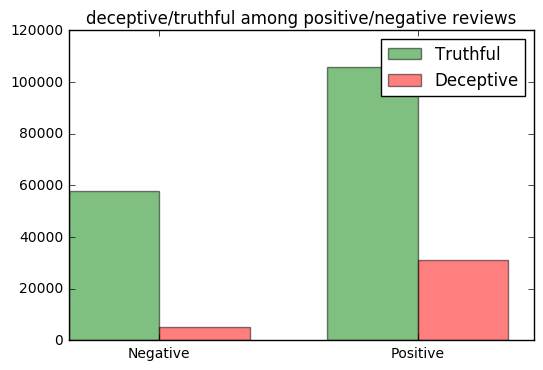

In [670]:
truthful_c  =  [class_distrbution[negative_truthful_i],class_distrbution[positive_truthful_i]]
deceptive_c = [class_distrbution[negative_deceptive_i],class_distrbution[positive_deceptive_i]]

fig, ax = plt.subplots()

index = np.arange(2)
bar_width = 0.35
opacity = 0.5

rects1 = plt.bar(index, truthful_c, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Truthful')

rects2 = plt.bar(index + bar_width, deceptive_c, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Deceptive')

plt.title('deceptive/truthful among positive/negative reviews')
plt.xticks(index + bar_width, ('Negative', 'Positive'))
plt.legend()
plt.show()

** 2) who are the top ten hotels with deceptive positive reviews?**


In [673]:
a=rating_classification[5:10]
a

,class,date,offering_id,rating
5,3,2012-12-19,1776857,5.0
6,3,2012-12-18,1776857,5.0
7,3,2012-12-20,1641016,5.0
8,3,2012-12-19,1641016,5.0
9,3,2012-12-19,1456560,4.0


In [738]:
#DISCLAIMER: the list is based on alpha-non-acurate prediction model and is for eudctional purpose only.
#the first 10 characters are hidden to protect brands

deceptive_positive_brands_count=rating_classification[rating_classification['class']==positive_deceptive_i].groupby(['offering_id']).size()
total_brands_count=rating_classification.groupby(['offering_id']).size()
deceptive_positive_brands_ratio=[(i,deceptive_positive_brands_count[i]/total_brands_count[i]) for i in deceptive_positive_brands_count.index]
deceptive_positive_brands_ratio.sort(key=lambda tup: tup[1], reverse=True) 
top_ten = deceptive_positive_brands_ratio[:10]
names = [offering[offering.id==offid[0]].name.values[0] for offid in top_ten]
['*'*8+name[8:] for name in names]

['********ity Inn',
 '********ue Inn & Suites Houston',
 '********Inn Houston',
 '******** York Hotel',
 '********ose Hotel',
 '********lmonico',
 '********dge',
 '********cholas Inn',
 '********i',
 '******** Best Value Inn & Suites-Houston/FM 249']

In [761]:
hotel_class = [offering[offering.id==offid[0]].hotel_class.values[0] for offid in deceptive_positive_brands_ratio[:100]]
ppf = pd.DataFrame({'stars':hotel_class}).groupby(['stars']).size()
ppf

stars
1.0     3
1.5     2
2.0    29
2.5    16
3.0     6
3.5     6
4.0     3
4.5     1
dtype: int64

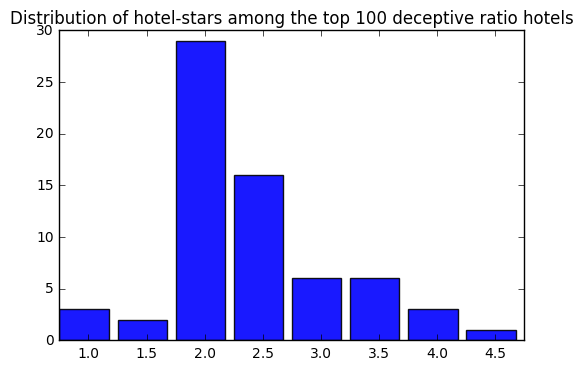

In [772]:
fig, ax = plt.subplots()

index = np.arange(8)
bar_width = 0.85
opacity = 0.9

rects1 = plt.bar(index, ppf, bar_width,
                 alpha=opacity,
                 color='blue')


plt.title('Distribution of hotel-stars among the top 100 deceptive ratio hotels')
plt.xticks(index + bar_width-0.35, ppf.index)
plt.show()

**3) what are the common review sequences followed by deceptive positive reviews? In particular do deceptive positive reviews are used to cover on previous truthful negative reviews? **

As the instructions require using both python and weka, this question will be analyzed using GSP algorithm in weka
==> prepare the data to be used in Weka. 


==> Data Mining - Practical Machine Learning Tools and Techniques (3rd Ed) - page 487 
GeneralizedSequentialPatterns implements a version of Srikant and Agrawal’s
(1996) GSP algorithm for finding large item sets that occur sequentially over time.
The input data must contain a special nominal attribute that groups transactions
(instances) together in time. All instances with the same nominal sequence identifier
are grouped together, defining a time window from which sequential patterns can
be extracted—for example, the identifier might group transactions according to the
day on which they occur. The instances within each group are treated as occurring
sequentially, in the order in which they appear in the data. Sequential large item sets,
consisting of item combinations that occur across transactions sequentially within a
group, are found that meet a user-supplied minimum-support threshold. The output
can be optionally filtered to show only those sequential patterns that contain specific
items the user is interested in.



In [796]:
import warnings
warnings.filterwarnings('ignore')

#choose 30 hotel with positive_deceptive_i in order to analyze the sequence pattern
selected_hotel=rating_classification[rating_classification['class']==positive_deceptive_i].groupby(['offering_id']).size().sort_values(ascending=False)[-100:-80]
selected_hotel_list=selected_hotel.index.tolist()
selected_hotel_string = ','.join(str(e) for e in selected_hotel_list)

export_data = rating_classification[rating_classification['offering_id'].isin(selected_hotel_list)]
export_data.replace(to_replace={'class': {negative_deceptive_i: 'negative'}}, inplace=True)
export_data.replace(to_replace={'class': {negative_truthful_i: 'negative'}}, inplace=True)
export_data.replace(to_replace={'class': {positive_deceptive_i: 'deceptive_positive'}}, inplace=True)
export_data.replace(to_replace={'class': {positive_truthful_i: 'positive'}}, inplace=True)
len(export_data.index)

364

In [797]:
f = open('output.arff', 'w')
f.write("@relation review_class_seqential\n\n")
f.write("@attribute customer {" + selected_hotel_string +"}\n")
f.write("@attribute 'rating' {rating=positive,rating=negative,rating=deceptive_positive}\n\n")
f.write("@data\n")

for row in export_data.itertuples():
    f.write(str(row[3]) + "," + "rating=" + row[1]+"\n")


 <img src="weka.png">

**Experiment steps:**
1-choose 20 hotel from the hotels who have high ratio of deceptive positive.
2-extract all reviews of these hotels, build arff (cell abovefile and run in weka

** Result-frequent 5,6 sequences ends with deceptive positive **
**5-sequences**

[1] <{rating=positive}{rating=positive}{rating=positive}{rating=negative}{rating=deceptive_positive}> (4)

[3] <{rating=positive}{rating=negative}{rating=positive}{rating=positive}{rating=deceptive_positive}> (4)

[4] <{rating=positive}{rating=negative}{rating=positive}{rating=negative}{rating=deceptive_positive}> (4)

[6] <{rating=negative}{rating=positive}{rating=positive}{rating=positive}{rating=deceptive_positive}> (4)

[7] <{rating=negative}{rating=positive}{rating=positive}{rating=negative}{rating=deceptive_positive}> (4)

[10] <{rating=negative}{rating=positive}{rating=negative}{rating=positive}{rating=deceptive_positive}> (4)

[11] <{rating=negative}{rating=positive}{rating=negative}{rating=negative}{rating=deceptive_positive}> (4)

[13] <{rating=negative}{rating=negative}{rating=positive}{rating=positive}{rating=deceptive_positive}> (4)

[14] <{rating=negative}{rating=negative}{rating=positive}{rating=negative}{rating=deceptive_positive}> (4)

**6-sequences**

[1] <{rating=positive}{rating=negative}{rating=positive}{rating=positive}{rating=negative}{rating=deceptive_positive}> (4)

[3] <{rating=negative}{rating=positive}{rating=negative}{rating=positive}{rating=positive}{rating=deceptive_positive}> (4)

[4] <{rating=negative}{rating=positive}{rating=negative}{rating=positive}{rating=negative}{rating=deceptive_positive}> (4)


** 4) would a 2-steps approach based on domain knowledge (like the one presented on anomaly detection showcase) improves the accuracy of the model? **

http://web.cs.wpi.edu/~cs548/f16/Showcase/CS548F16_Showcase_Anomaly_Detection.pptx

 <img src="twosteps.png">

** what features we could extract from the text for the anomaly detecion step?**

Some online reviews are too good to be true; Cornell computers spot 'opinion spam'
http://bit.ly/2g6ou9X 


"The researchers then applied computer analysis based on subtle features of text. Truthful hotel reviews, for example, are more likely to use concrete words relating to the hotel, like "bathroom," "check-in" or "price." Deceivers write more about things that set the scene, like "vacation," "business trip" or "my husband." Truth-tellers and deceivers also differ in the use of keywords referring to human behavior and personal life, and sometimes in features like the amount of punctuation or frequency of "large words." In parallel with previous analysis of imaginative vs. informative writing, deceivers use more verbs and truth-tellers use more nouns."

Featuers to extract:

1)amount of punctuation

2)total nouns - total verbs 

3)length of the review.

4) adjective and adverbs ratio


In [798]:
import nltk
#fit the anomly detection model using truthful reviews.
data_set = dataset.data

rev_length = [len(data) for data in data_set]
tokens = [nltk.word_tokenize(data) for data in data_set]
taggeds = [nltk.pos_tag(token,tagset='universal') for token in tokens] 
tag_fds = [nltk.FreqDist(tag for (word, tag) in tagged) for tagged in taggeds]
totals = [tag_fd['ADJ'] + tag_fd['NOUN'] + tag_fd['PRON']+tag_fd['ADV']+tag_fd['VERB'] for tag_fd in tag_fds]
# define featuers.
punctuation_amount = [tag_fd['.'] for tag_fd in tag_fds]
adv_adj_ratio = [(tag_fd['ADJ'] + tag_fd['ADV'])/total for tag_fd,total in zip(tag_fds,totals)]
noun_ratio = [tag_fd['NOUN']/total for tag_fd,total in zip(tag_fds,totals)]
verb_noun_diff = [tag_fd['VERB'] - tag_fd['NOUN'] for tag_fd in tag_fds]


In [818]:
from sklearn.svm import OneClassSVM
# combine all extractd featuers in one data frame
features = {'Length': rev_length,'punctuation_amount': punctuation_amount,'adv_adj_ratio': adv_adj_ratio,'noun_ratio': noun_ratio,'verb_noun_diff': verb_noun_diff}
df = pd.DataFrame(features)

x_truthful_traning = df[(dataset.target==positive_truthful_i) | (dataset.target==negative_truthful_i)]

anomly_detector = OneClassSVM()
docs_train_1, docs_test_1 = train_test_split(
    x_truthful_traning, test_size=0.10, random_state=None)

anomly_detector.fit(docs_train_1)

# we fit on 90% of the non-outliers and test on the whole including outliers.
# the test include part of the training data! evulation may bias - Fix that later and test on docs_test.
ad_predicted = anomly_detector.predict(df)

# build the true target, mask truthful with 1 - not outlier, deceptive with -1, outliers.
ture_target=[1 if (x==positive_truthful_i) | (x ==negative_truthful_i) else -1 for x in dataset.target]


In [820]:
# evalution for the anomly detection
print("**Classification Report**\n")
print(metrics.classification_report(ture_target, ad_predicted,target_names=['outlier','non-outlier']))


**Classification Report**

             precision    recall  f1-score   support

    outlier       0.58      1.00      0.74       801
non-outlier       1.00      0.28      0.44       801

avg / total       0.79      0.64      0.59      1602



** build 2 steps prediction model **

one advantage of having unsupervised step is that we could train it with part of tripadvisor data too. The training data we have includes 800 reviews classified as deceptive.  With unsupervised step we can train the data on large number from tripadvisor(though we can’t use the novelty approach that I used here as the data will be already polluted with outliers). in this context I still use the same training/test data.

which step to run first? anomaly detection or the text classifier?
depends which error we want to reduce! the false positive or false negative,
the orginal confusion matrix shows false positive ratio is higher than false negative. apprently the giving 2nd chance to deceptive to become truthful will give better result. anyway we will build the two models and then evaluote them


In [821]:
def extract_featuers(input_data):
    rev_length = [len(data) for data in input_data]
    tokens = [nltk.word_tokenize(data) for data in input_data]
    taggeds = [nltk.pos_tag(token,tagset='universal') for token in tokens] 
    tag_fds = [nltk.FreqDist(tag for (word, tag) in tagged) for tagged in taggeds]
    totals = [tag_fd['ADJ'] + tag_fd['NOUN'] + tag_fd['PRON']+tag_fd['ADV']+tag_fd['VERB'] for tag_fd in tag_fds]
    punctuation_amount = [tag_fd['.'] for tag_fd in tag_fds]
    adv_adj_ratio = [(tag_fd['ADJ'] + tag_fd['ADV'])/total for tag_fd,total in zip(tag_fds,totals)]
    noun_ratio = [tag_fd['NOUN']/total for tag_fd,total in zip(tag_fds,totals)]
    verb_noun_diff = [tag_fd['VERB'] - tag_fd['NOUN'] for tag_fd in tag_fds]
    features = {'Length': rev_length,'punctuation_amount': punctuation_amount,'adv_adj_ratio': adv_adj_ratio,'noun_ratio': noun_ratio,'verb_noun_diff': verb_noun_diff}
    return pd.DataFrame(features)

# define featuers.
def mask_deceptive(value):
    if (value == negative_deceptive_i):
        return negative_truthful_i
    elif (value == positive_deceptive_i):
        return positive_truthful_i
    else:
        return value

def mask_truthful(value):
    if (value == negative_truthful_i):
        return negative_deceptive_i
    elif (value == positive_truthful_i):
        return positive_deceptive_i
    else:
        return value

def ad_then_clf(input_data):
    f = extract_featuers(input_data)
    ad_result = anomly_detector.predict(f)
    X_vect = TfidfVect.transform(input_data).toarray()
    clf_result = clf.predict(X_vect)
    # return the clf result if anomly return 1;
    # if anomly detect -1 (outlier), mask the deceptive positive/negative with truthful positive/negative respectvely. 
    result=[cf if (ad==-1) else mask_deceptive(cf) for cf,ad in zip(clf_result,ad_result)]
    return result

def clf_then_ad(input_data):
    f = extract_featuers(input_data)
    ad_result = anomly_detector.predict(f)
    X_vect = TfidfVect.transform(input_data).toarray()
    clf_result = clf.predict(X_vect)
    # return the clf result if it deceptive
    # otherwise check if it's true outlier.
    result=[cf if ((cf==negative_deceptive_i) | (cf==positive_deceptive_i)) else cf if (ad==1) else mask_truthful(cf) for cf,ad in zip(clf_result,ad_result)]
    return result


**Evalution of the two steps approaches**

In [826]:
# Creating new split will increse the risk of mixing test with traing data. use the original split in the 1st cell
# two_steps_docs_train, two_steps_docs_test, two_steps_y_train, two_steps_y_test = train_test_split(
#    dataset.data, dataset.target, test_size=0.10, random_state=None)

# use origianl split to avoid mixing training data with test data.
two_steps_docs_test = docs_test
two_steps_y_test= y_test

clf_then_ad_result = clf_then_ad(two_steps_docs_test)
ad_then_clf_result = ad_then_clf(two_steps_docs_test)

**Classification Report clf then ad**

                    precision    recall  f1-score   support

negative_deceptive       0.56      0.95      0.70        42
 negative_truthful       1.00      0.17      0.30        40
positive_deceptive       0.61      1.00      0.76        44
 positive_truthful       1.00      0.29      0.44        35

       avg / total       0.78      0.63      0.56       161

**Confusion Matrixclf then ad**

[[40  0  2  0]
 [31  7  2  0]
 [ 0  0 44  0]
 [ 1  0 24 10]]
0: negative_deceptive  1: negative_truthful
2: positive_deceptive  3: positive_truthful


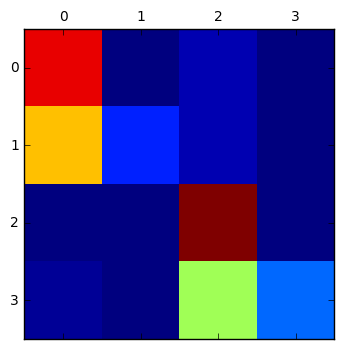

**Classification Report ad then clf **

                    precision    recall  f1-score   support

negative_deceptive       0.94      0.81      0.87        42
 negative_truthful       0.84      0.90      0.87        40
positive_deceptive       0.88      0.98      0.92        44
 positive_truthful       0.94      0.89      0.91        35

       avg / total       0.90      0.89      0.89       161

**Confusion Matrix ad then clf **

[[34  6  2  0]
 [ 2 36  1  1]
 [ 0  0 43  1]
 [ 0  1  3 31]]
0: negative_deceptive  1: negative_truthful
2: positive_deceptive  3: positive_truthful


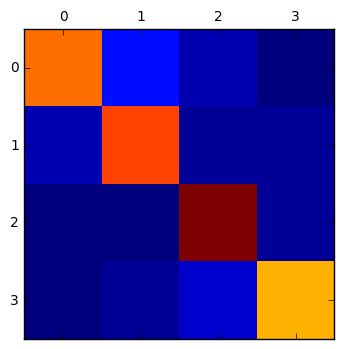

In [827]:

print("**Classification Report clf then ad**\n")
print(metrics.classification_report(y_test, clf_then_ad_result,target_names=dataset.target_names))
print("**Confusion Matrixclf then ad**\n")
cm = metrics.confusion_matrix(y_test, clf_then_ad_result)
print(cm)
print("0: " + dataset.target_names[0] + "  1: " + dataset.target_names[1])
print("2: " + dataset.target_names[2] + "  3: " + dataset.target_names[3]) 
plt.matshow(cm)
plt.show()


print("**Classification Report ad then clf **\n")
print(metrics.classification_report(y_test, ad_then_clf_result,target_names=dataset.target_names))
print("**Confusion Matrix ad then clf **\n")
cm = metrics.confusion_matrix(y_test, ad_then_clf_result)
print(cm)
print("0: " + dataset.target_names[0] + "  1: " + dataset.target_names[1])
print("2: " + dataset.target_names[2] + "  3: " + dataset.target_names[3]) 
plt.matshow(cm)
plt.show()